# Introduction

## Package features

This package provides functionality to characterize sets of genomic regions. One or more sets of genomic regions are analyzed for the strength and significance of their association with certain biological features. This includes adjacency to genes from meaningful genesets and overlap with genomic regions such as ChIP-Seq peaks or predicted TFBS.

Common to all analyses in this package is the notion of comparing a set of regions of interest (ROIs) with a set of background regions, in order to find out whether a biological feature is enriched or depleted in the ROIs compared to the background. Different scenarios are supported:

1. Comparison within an experimental universe. In modern studies, we often have large datasets covering many considerably different biological populations (or single cells which can be grouped in various distinct clusters). For example, a dataset may characterize various distinct hematopoietic populations. Such studies typically aim to find and characterize various sets of ROIs characterizing different populations. In these cases, often the set of all identified ROIs can serve as a background against which individual ROI subsets are compared. Such tests answer the question: what distinguishes the ROI set characterizing population A from the ROIs observed in other populations?
2. When the experimental design is not compatible with performing comparisons within the universe of experimentally observed ROIs, two approaches are supported:
    1. Translate the observed ROIs into a set of associated genes and perform standard overrepresentation enrichment analysis.
    2. Compare the observed ROIs against a simulated background (work in progress).

## Package maturity

This package is unreleased and unpublished software, but we use it often in in-house projects. We can not yet provide support for external users. Also, we do change the API from time to time, without regard for health and safety of external users. Given this development stage, we also do not yet provide a complete documentation.

## Content of this vignette

This vignette is not meant as a complete documentation of all package features (cf. package maturity above). Rather, this notebook is intended to showcase how the package was used to perform some recently published analyses, in order to make the performed analyses more transparent.

# Imports

Run these imports prior to all examples

In [1]:
import pandas as pd

import region_set_profiler as rsp

import codaplot as co
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests

In [2]:
%matplotlib inline

In [3]:
def mht_correction(p_value_df):
    pvals_corrected = multipletests(
        p_value_df.to_numpy().flatten(order="C"),
        method="fdr_bh",
        returnsorted=False,
    )[1]
    q_value_df = pd.DataFrame(
        pvals_corrected.reshape(p_value_df.shape),
        index=p_value_df.index,
        columns=p_value_df.columns,
    )
    return q_value_df

# Enrichments within an experimental universe

See introduction above - these tools are meant to characterize subsets of large sets of ROIs against each other.

## Test for association with genesets

In this analysis type, we are interested in testing whether subsets of ROIs from a large experimental universe are significantly associated with certain genesets, i.e. whether the ROI subsets are in proximity of the genes of certain genesets more often than the background regions.

### Preparation of input data

What is sufficient proximity to associate a genomic region with a certain gene? It will depend on the question at hand. Therefore, regionset_profiler makes no attempt at providing a general solution. Rather, the user provides a gene annotation for all ROIs, and decides about how to filter for biological meaningful proximity. regionset_profiler expects only the following information as a result of this analysis: a Series mapping each ROI to be used in the test to a gene.

For this vignette, we provide 3,000 clustered toy DMRs (differentially methylated regions), placed (with considerable noise) in proximity of characteristic genes of four hematopoietic populations (real world datasets in this analysis type would be much larger, of course). Can we find out which DMR cluster belongs to which population?

For this example, gene annotation has already been performed. You can use any decent gene annotation tool of your liking and adapt gene annotations in any way you see fit to get a set of ROI-to-gene annotations with some confidence. In this case, we used our in-house tool [gftanno](https://github.com/stephenkraemer/gtfanno), but again this should be chosen on a case-by-case basis. 

Here are the annoteted DMRs

In [4]:
simulated_dmr_clusters = pd.read_pickle("simulated_dmr_clusters.p")
simulated_dmr_clusters.head(5)

Gene GenomicRegion ClusterID
Chromosome Start    End                                      
1          7139742  7139990   Gm26983      Promoter        C1
           9548071  9548115    Adhfe1      Promoter        C2
           10316090 10316863             intergenic        C2
           16297792 16297835    Stau2        intron        C3
           33482222 33482405  Gm29228      Promoter        C2

This dataframe contains annotations to a gene (if possible) and genomic region (promoter, intron, exon etc.) as described here: [gtfanno](https://github.com/stephenkraemer/gtfanno). It's up to you to decide which annotations you want to consider. All of them? Or just the promoter annotations? Let's use everything within a gene or within a Promoter, and exclude everything else (for example intergenic DMRs which could not be associated with a gene). The further away from a gene we are, the less confidence we have in the annotations... Of course, if you had 4C data etc., you would integrate this at this step to get better annotations!

In [5]:
dmrs_filtered = simulated_dmr_clusters.loc[
    simulated_dmr_clusters["GenomicRegion"].isin(
        ["Promoter", "5'-UTR", "3'-UTR", "intron", "exon"]
    )
]
dmrs_filtered

Gene GenomicRegion ClusterID
Chromosome Start     End                                       
1          7139742   7139990    Gm26983      Promoter        C1
           9548071   9548115     Adhfe1      Promoter        C2
           16297792  16297835     Stau2        intron        C3
           33482222  33482405   Gm29228      Promoter        C2
           33594864  33596335     Prim2        intron        C3
...                                 ...           ...       ...
9          121008086 121008374     Ulk4        intron        C3
           121379312 121379380    Trak1      Promoter        C2
           121896742 121897004    Ackr2      Promoter        C3
           123078354 123078533   Zdhhc3        intron        C2
           123186193 123186646    Cdcp1        intron        C2

[2241 rows x 3 columns]

These are the regions we want to use for our enrichment analysis!

Next, we need to define the genesets we are interested in. These files should be in the common GMT format (which is for example the format used by MSIGDB). For this demo, we have prepared some [marker genesets for hematopoietic populations](marker-genes-100.gmt)

### Test and quantify association

We start by generating a GenesetOverlapStats object (if we were interested in comparing against other genomic intervals instead of regions, we would create a OverlapStats object instead).

In [6]:
overlap_stats = rsp.GenesetOverlapStats(
    annotations=dmrs_filtered["Gene"].str.upper(), genesets_fp="marker-genes-100.gmt"
)

We can use the compute method to identify overlaps between ROIs and the genesets:

In [7]:
overlap_stats.compute()

The result is a coverage df, detailing for each ROI whether it is in proximity to a gene from a geneset:

In [8]:
overlap_stats.coverage_df

B-cells  CFU-E  HSC  Neutrophils  Monocytes
Chromosome Start     End                                                   
1          7139742   7139990          0      0    0            0          0
           9548071   9548115          0      0    0            0          0
           16297792  16297835         0      0    0            0          0
           33482222  33482405         0      0    0            0          0
           33594864  33596335         0      0    0            0          0
...                                 ...    ...  ...          ...        ...
9          121008086 121008374        0      0    0            0          0
           121379312 121379380        0      0    0            0          0
           121896742 121897004        0      0    0            0          0
           123078354 123078533        0      0    0            0          0
           123186193 123186646        0      0    0            0          0

[2241 rows x 5 columns]

There are no hits in the head and tail - how many are there overall?

In [9]:
overlap_stats.coverage_df.sum()

B-cells        16
CFU-E           7
HSC            21
Neutrophils     9
Monocytes       9
dtype: int64

Next, we use the cluster information to aggregate this hits per cluster

In [11]:
cluster_overlap_stats = overlap_stats.aggregate(dmrs_filtered["ClusterID"])

In [12]:
cluster_overlap_stats.hits

dataset,B-cells,CFU-E,HSC,Neutrophils,Monocytes
cluster_id,,,,,
C1,4,4,17,1,1
C2,1,0,0,8,5
C3,11,3,4,0,3


We already have an intuition now - look like cluster C3 is associated with B cell marker genes, cluster C1 with HSC markers and cluster C2 with Neutrophil markers. But this needs to be tested. Let's test this, using the two-sided Fisher's exact test by default!

In [13]:
cluster_overlap_stats.test_per_cluster_per_feature()

The p-values are here:

In [14]:
cluster_overlap_stats.cluster_pvalues

dataset,B-cells,CFU-E,HSC,Neutrophils,Monocytes
cluster_id,,,,,
C1,0.445164,0.251156,0.000022,0.172590,0.172590
C2,0.028799,0.103667,0.000282,0.000826,0.163533
C3,0.004754,0.686885,0.245615,0.065344,1.000000


And here are the log-odds ratios:

In [15]:
cluster_overlap_stats.log_odds_ratio

dataset,B-cells,CFU-E,HSC,Neutrophils,Monocytes
cluster_id,,,,,
C1,-0.506878,1.202550,2.751653,-1.299779,-1.299779
C2,-1.975638,-1.969892,-3.442843,3.221577,1.305871
C3,2.104289,0.767077,-0.769356,-2.243714,0.279752


Finally, perform MHT correction:

In [16]:
q_values = mht_correction(cluster_overlap_stats.cluster_pvalues)

### Visualize the results

#### Log-odds

Let's first look at the log-odds ratios:

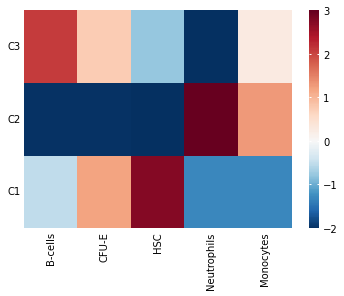

In [17]:
fig, ax = plt.subplots(1, 1)
_ = co.heatmap(
    df=cluster_overlap_stats.log_odds_ratio,
    ax=ax,
    xticklabels=True,
    yticklabels=True,
    yticklabel_side='left',
    cmap="RdBu_r",
    show_guide=True,
    norm=co.plotting.MidpointNormalize(vmin=-2, midpoint=0, vmax=3),
)

#### P-values

To confirm the trends we see in the log-odds plot, let's visualize the p-values. One helpful visualization is a heatmap of `-np.sign(cluster_overlap_stats.log_odds_ratio) * np.log10(q_values)`

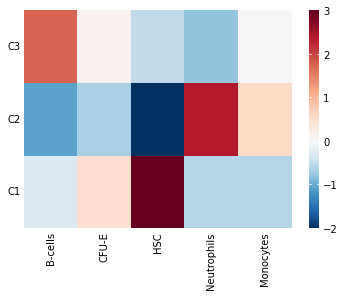

In [18]:
fig, ax = plt.subplots(1, 1)
_ = co.heatmap(
    df=-np.sign(cluster_overlap_stats.log_odds_ratio) * np.log10(q_values),
    ax=ax,
    xticklabels=True,
    yticklabels=True,
    yticklabel_side='left',
    cmap="RdBu_r",
    show_guide=True,
    norm=co.plotting.MidpointNormalize(vmin=-2, midpoint=0, vmax=3),
)

We have winners - this toy example clearly provided DMRs in proximity (or covering) genes from B cell, HSC and Neutrophil marker genesets. We can distinguish them from CFU-E and Monocyte genesets - but we can also see that there is some overlap between the CFU-E and HSC, and the Neutrophil and Monocyte annotations. Next we might want to check whether that is due to overlap between the genesets, or due to the presence of different genesets within our DMR clusters - but that's beyond the basic usage we wanted to introduce here :)